In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jernerics.generate.generator import DataGenerator
from jernerics.generate.data import GaussianDataGenerator, LinearDependentTransformer, GaussianNoiseTransformer
from jernerics.generate.parameters import GaussianParametersGenerator, SparseParametersTransformer, ExponentialScaledParametersTransformer
from jernerics.generate.labels import LinearLabelComputer
from models import WeightedLasso

%load_ext autoreload
%autoreload 2

In [2]:
data_generator = (
    DataGenerator()
    .add_step(
        label="gaussian_params", step=GaussianParametersGenerator(mean=0, std=1),
    )
    .add_step(
        label="sparse_params",
        step=SparseParametersTransformer(sparsity=0.9),
        deps=["gaussian_params"],
    )
    .add_step(
        label="scale_params",
        step=ExponentialScaledParametersTransformer(scale_factor=1e10),
        deps=["sparse_params"],
    )
    .add_step(
        label="gaussian_data",
        step=GaussianDataGenerator(mean=0, std=1),
    )
    # .add_step(
    #     label="linear_dependent_data",
    #     step=LinearDependentTransformer(percent_independent=0.1, std=1e0, noise_std=1e0),
    #     deps=["gaussian_data"],
    # )
    .add_step(
        label="linear_labels",
        step=LinearLabelComputer(),
        # deps=["linear_dependent_data", "scale_params"],
        deps=["gaussian_data", "scale_params"],
    )
    .add_step(
        label="gaussian_noise",
        step=GaussianNoiseTransformer(std=1e0),
        deps=["gaussian_data"],
    )
)

X, y, theta = data_generator.generate(n_samples=256, n_features=100, random_state=33)


print("Generated X shape:", X.shape)
print("Generated y shape:", y.shape)
print("Generated theta shape:", theta.shape)
print("Sparsity of theta:", np.sum(theta == 0) / len(theta))

Generated X shape: (256, 100)
Generated y shape: (256,)
Generated theta shape: (100,)
Sparsity of theta: 0.9


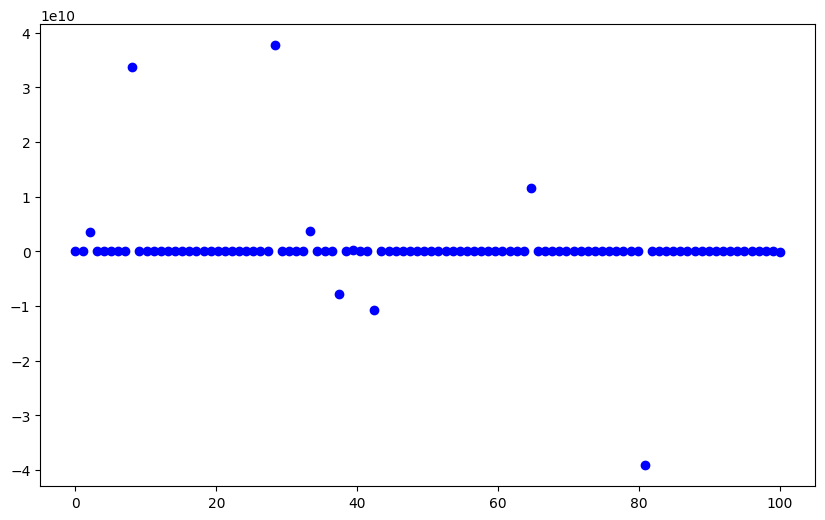

In [3]:
plt.figure(figsize=(10, 6))

plt.scatter(np.linspace(0, len(theta), len(theta)), theta, color='blue', label='Theta values')
# plt.scatter(np.linspace(0, len(theta), len(theta)), (1/(np.abs(np.reshape(theta, (-1, 1))) + 1e-1)), color='blue', label='Theta values')
plt.show()

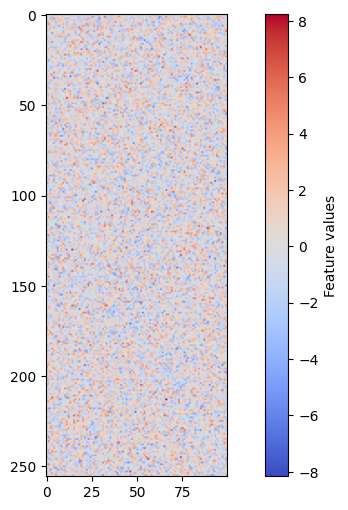

In [4]:
plt.figure(figsize=(10, 6))

plt.imshow(X, aspect='equal', cmap='coolwarm')
plt.colorbar(label='Feature values')
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(X[:,0], X[:,1], X[:,2], lw=0.5)
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.set_title("Lorenz System 3D Trajectory")
plt.show()

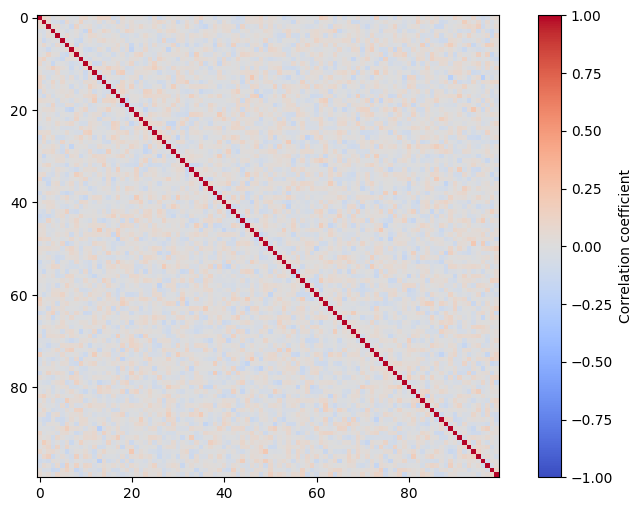

In [5]:
plt.figure(figsize=(10, 6))
plt.imshow(np.corrcoef(X.T), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation coefficient')
plt.show()


In [6]:
# (1/(np.abs(np.reshape(theta, (-1, 1))) + 1e-1))

In [7]:
model = WeightedLasso(weights=(1/(np.abs(np.reshape(theta, (-1, 1))) + 1e-2)), alpha=1e2, max_iter=100_000)
# model = WeightedLasso(weights=np.ones((theta.shape[0], 1)), alpha=1e-4, max_iter=100_000)
model.fit(X=X, y=y)

Problem status did not solve to optimality: user_limit


/home/jerry/Research/code/weight_perturbation/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


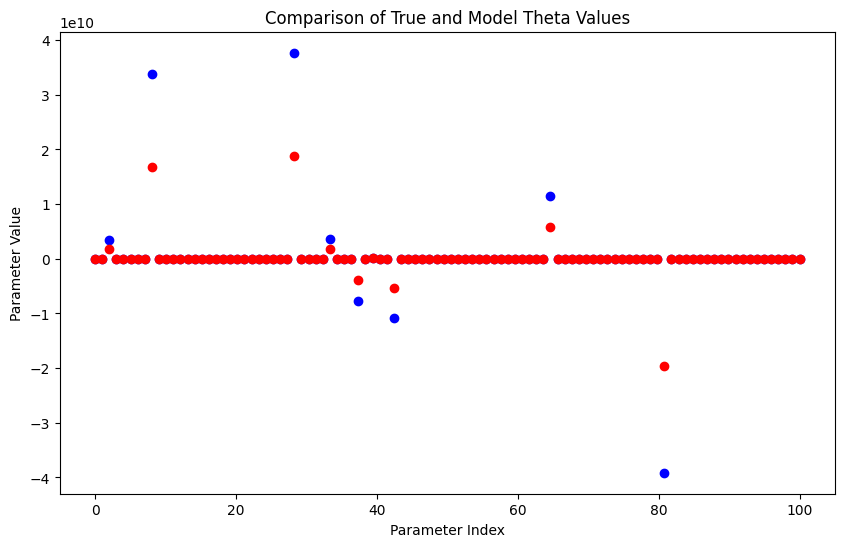

In [8]:
plt.figure(figsize=(10, 6))

plt.title('Comparison of True and Model Theta Values')
plt.scatter(np.linspace(0, len(theta), len(theta)), theta, color='blue', label='True Theta values')
plt.scatter(np.linspace(0, len(model.coef_.T), len(model.coef_.T)), model.coef_.T, color='red', marker='o', label='Model Theta values')
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Value')

plt.show()

In [9]:
model.coef_.shape, X.shape, y.shape

((1, 100), (256, 100), (256,))

In [10]:
model.score(X=X,y=y)

1.0

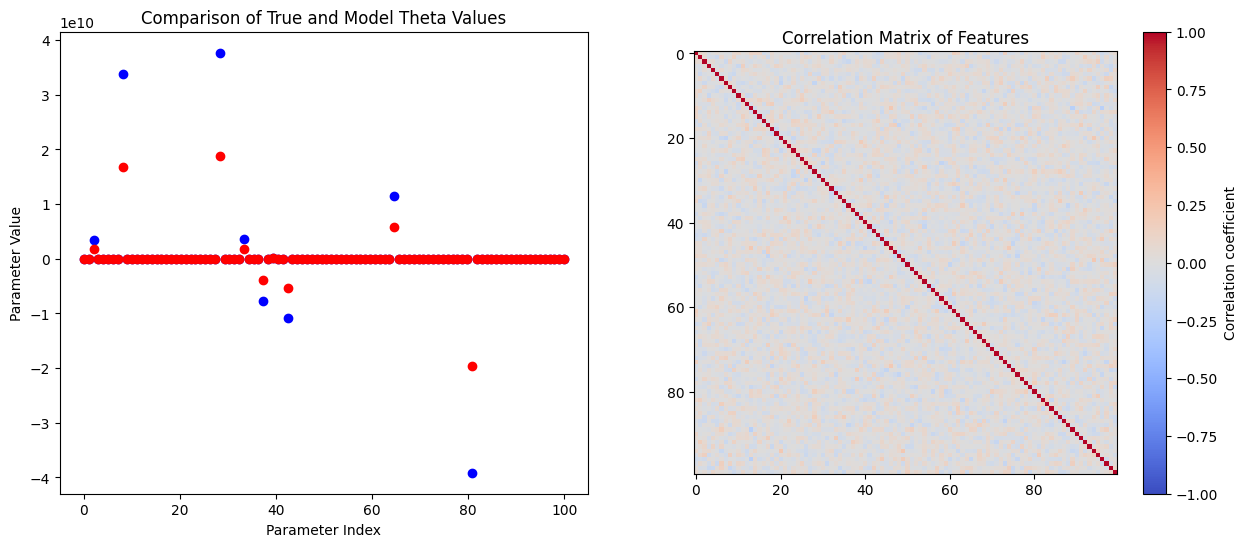

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].scatter(np.linspace(0, len(theta), len(theta)), theta, color='blue', label='True Theta values')
ax[0].scatter(np.linspace(0, len(model.coef_.T), len(model.coef_.T)), model.coef_.T, color='red', marker='o', label='Model Theta values')
ax[0].set_xlabel('Parameter Index')
ax[0].set_ylabel('Parameter Value')
ax[0].set_title('Comparison of True and Model Theta Values')
ax[1].imshow(np.corrcoef(X.T), cmap='coolwarm', vmin=-1, vmax=1)
ax[1].set_title('Correlation Matrix of Features')
plt.colorbar(ax[1].imshow(np.corrcoef(X.T), cmap='coolwarm', vmin=-1, vmax=1), ax=ax[1], label='Correlation coefficient')


plt.show()